# **Project Objectives:**


*   To train and fine-tune a large language
model specifically for extracting structured information from Information Retrieval research papers.
*   To compare the performance of a custom trained LLM with pre-trained models in extracting relevant data.
*   To identify and address potential challenges in the automated extraction process, such as handling diverse document formats and terminologies.


### **How to Run This Notebook**

To run this notebook, you need to set up your Hugging Face API token as a secret in Google Colab:

1. Go to `Runtime` > `Run All`.
2. Enter `HF_TOKEN` as the secret name.
3. Paste your Hugging Face API token as the value.
4. Run the notebook cells as usual.

Your token will be securely stored and used to authenticate API requests during the execution of this notebook.


#Installing Essential Packages

In [1]:
!pip install kaggle \
    transformers \
    datasets \
    nltk \
    evaluate \
    rouge_score \
    wordcloud \
    seaborn \
    bert-score


#Importing the Necessary Libraries

In [2]:
from google.colab import userdata
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import evaluate
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from transformers import (
    GPT2Tokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    pipeline,
    AdamW,
    get_linear_schedule_with_warmup,
    TrainerCallback
)
from transformers import EncoderDecoderModel, BertTokenizer
from datasets import Dataset, load_metric
import torch
import torch.nn as nn
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler,
                              SequentialSampler)
import torch.nn.functional as F
from math import exp
from tabulate import tabulate
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from collections import Counter
from bert_score import score
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Version v4.12.0 introduces")



In [3]:
# Download the required nltk data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#DATASET LOADING

##Downloading, Unzipping, and Loading the ArXiv Metadata Dataset

In [4]:
arxiv_path = 'arxiv-metadata-oai-snapshot.json'

# Check if the dataset file already exists
if not os.path.exists(arxiv_path):
    print("Downloading the dataset...")

    # Download the dataset
    !kaggle datasets download -d Cornell-University/arxiv
    print("Dataset downloaded!")

    # Unzip the downloaded file
    !unzip arxiv.zip
    print("Dataset unzipped!")
else:
    print("Dataset already exists!")

# Load the data from the JSON file
data = []
with open(arxiv_path, 'r') as file:
    for line in tqdm(file, desc='Loading Data'):
        data.append(json.loads(line))
print(f'\nFinished loading data.\nTotal Records: {len(data)}')

# Get the size in bytes
arxiv_size = os.path.getsize(arxiv_path)

# Convert to Gigabytes (GB)
file_size_gb = arxiv_size / (1024 * 1024 * 1024)

print(f"File size: {file_size_gb:.2f} GB")

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.32G/1.32G [00:18<00:00, 91.4MB/s]
100% 1.32G/1.32G [00:18<00:00, 78.4MB/s]
Dataset downloaded!
Archive:  arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  
Dataset unzipped!


Loading Data: 2546904it [01:15, 33923.01it/s]


Finished loading data.
Total Records: 2546904
File size: 4.01 GB


##Filtering ArXiv Data for 'cs.IR' Category and Saving to CSV

In [5]:
# Filter the data with progress bar
filtered_data = []
for paper in tqdm(data, desc="Filtering data"):
    if 'cs.IR' in paper['categories']:
        filtered_data.append(paper)

# Create a dataframe
df_ir = pd.DataFrame(filtered_data)

# Save the DataFrame to a CSV file
df_ir.to_csv('arxiv_ir.csv', index=False)

# Get the size of the saved CSV file
file_size_ir = os.path.getsize('arxiv_ir.csv')
file_size_mb = file_size_ir / (1024 * 1024)
file_size_gb = file_size_ir / (1024 * 1024 * 1024)

print(f'Total Records of Computer Science Information Retrieval (cs.IR) category:'
      f'{len(df_ir)}'
      )
# Print file sizes in MB and GB
print(f"CSV file size: {file_size_mb:.2f} MB ({file_size_gb:.2f} GB)")

Filtering data: 100%|██████████| 2546904/2546904 [00:01<00:00, 1403925.43it/s]


Total Records of Computer Science Information Retrieval (cs.IR) category:17841
CSV file size: 29.03 MB (0.03 GB)


In [6]:
# The first few rows of the filtered data contain only IR papers
df_ir.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.1158,Bernardo Huberman,Fang Wu and Bernardo A. Huberman,Novelty and Collective Attention,None,None,10.1073/pnas.0704916104,None,cs.CY cs.IR physics.soc-ph,None,The subject of collective attention is centr...,"[{'version': 'v1', 'created': 'Mon, 9 Apr 2007...",2009-11-13,"[[Wu, Fang, ], [Huberman, Bernardo A., ]]"
1,0704.1676,Kristina Lerman,"Kristina Lerman, Anon Plangprasopchok and Chio...",Personalizing Image Search Results on Flickr,"12 pages, submitted to AAAI07 workshop on Inte...",None,None,None,cs.IR cs.AI cs.CY cs.DL cs.HC,None,The social media site Flickr allows users to...,"[{'version': 'v1', 'created': 'Thu, 12 Apr 200...",2007-05-23,"[[Lerman, Kristina, ], [Plangprasopchok, Anon,..."
2,0704.2902,Stefan Pohl,"Stefan Pohl, Filip Radlinski and Thorsten Joac...",Recommending Related Papers Based on Digital L...,"2 pages, 3 postscript figures, to appear in pr...",None,None,None,cs.DL cs.IR,None,An important goal for digital libraries is t...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ], [Radlinski, Filip, ], [Joac..."
3,0704.2963,Stefan Pohl,Stefan Pohl,Using Access Data for Paper Recommendations on...,"73 pages, 31 figures, Master's Thesis",None,None,None,cs.DL cs.IR,None,This thesis investigates in the use of acces...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ]]"
4,0704.3316,Ciro Cattuto,"Ciro Cattuto, Andrea Baldassarri, Vito D. P. S...",Vocabulary growth in collaborative tagging sys...,"6 pages, 7 figures",None,None,None,cs.IR cond-mat.stat-mech cs.CY physics.data-an,None,We analyze a large-scale snapshot of del.ici...,"[{'version': 'v1', 'created': 'Wed, 25 Apr 200...",2007-05-23,"[[Cattuto, Ciro, ], [Baldassarri, Andrea, ], [..."


#Data Exploration and Analysis

##Data Inspection and Summary Analysis for ArXiv cs.IR Subset

In [7]:
# Loading and Previewing Data
print("IR Dataset Information:")
df_ir.info()

# Printing the missing values in the Data
print("\nCount of Missing Values:")
print(df_ir.isnull().sum())

# Loading the summary statistics of Data
print("\nSummary Statistics:")
print(df_ir.describe())

IR Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17841 entries, 0 to 17840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              17841 non-null  object
 1   submitter       17841 non-null  object
 2   authors         17841 non-null  object
 3   title           17841 non-null  object
 4   comments        11214 non-null  object
 5   journal-ref     2383 non-null   object
 6   doi             3744 non-null   object
 7   report-no       277 non-null    object
 8   categories      17841 non-null  object
 9   license         17509 non-null  object
 10  abstract        17841 non-null  object
 11  versions        17841 non-null  object
 12  update_date     17841 non-null  object
 13  authors_parsed  17841 non-null  object
dtypes: object(14)
memory usage: 1.9+ MB

Count of Missing Values:
id                    0
submitter             0
authors               0
title                 0


##Custom Plotting Functions for Exploratory Data Analysis (EDA)

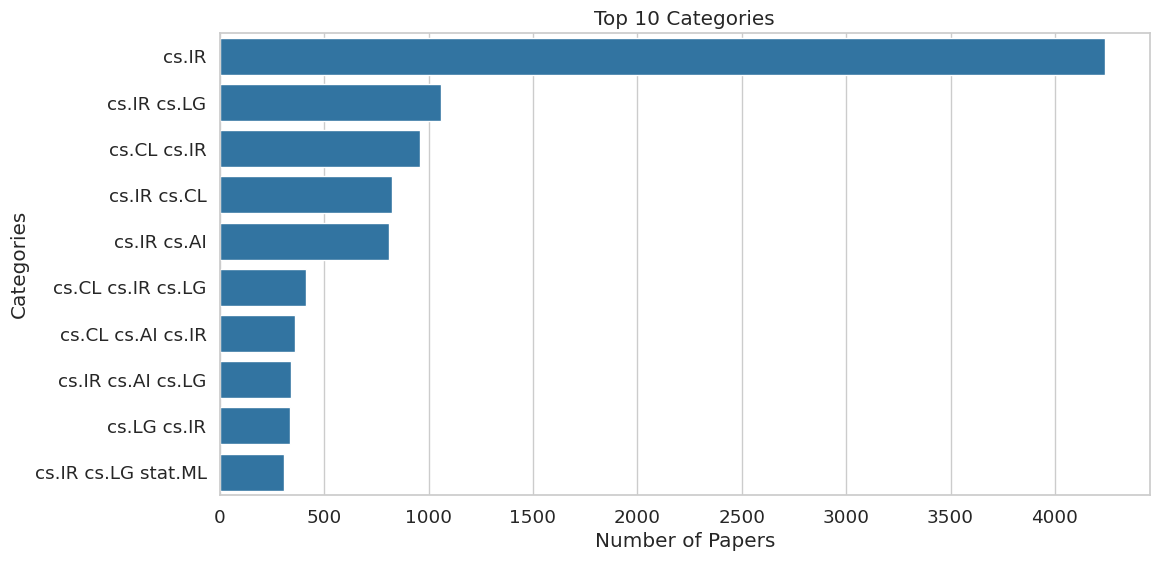

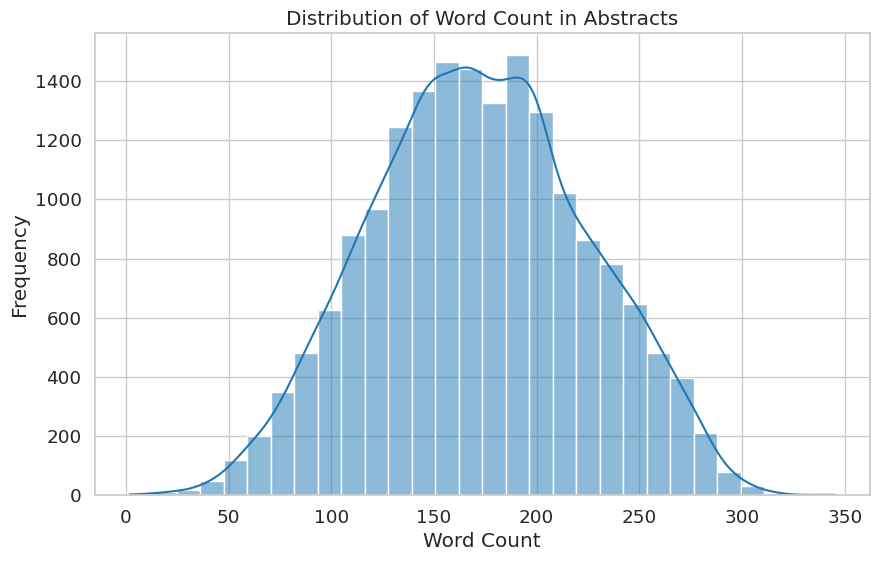

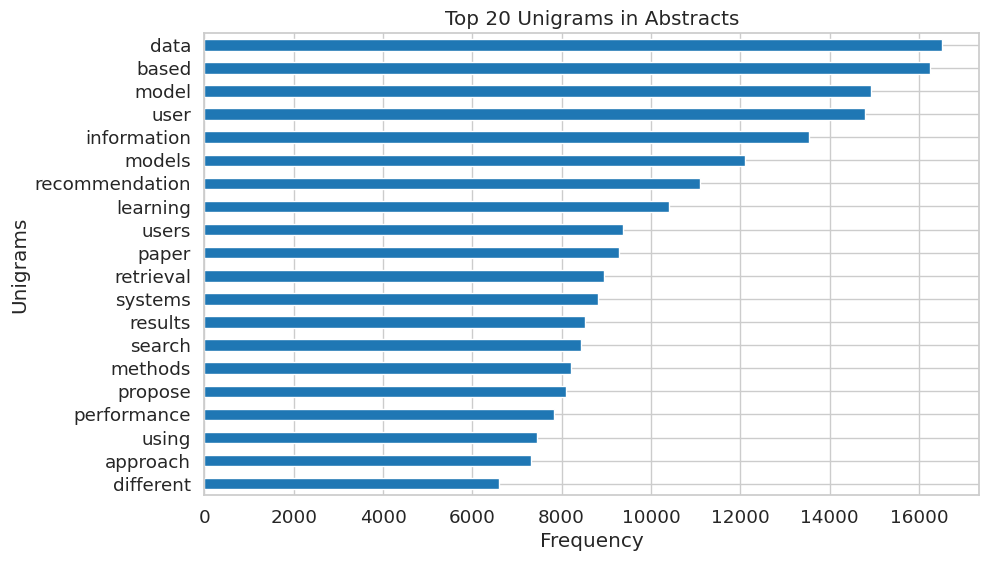

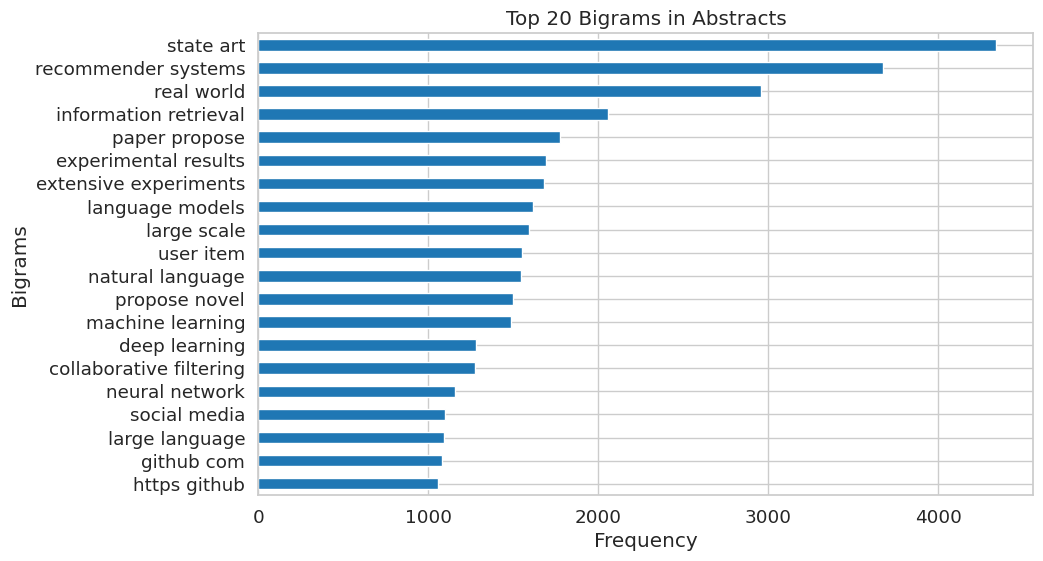

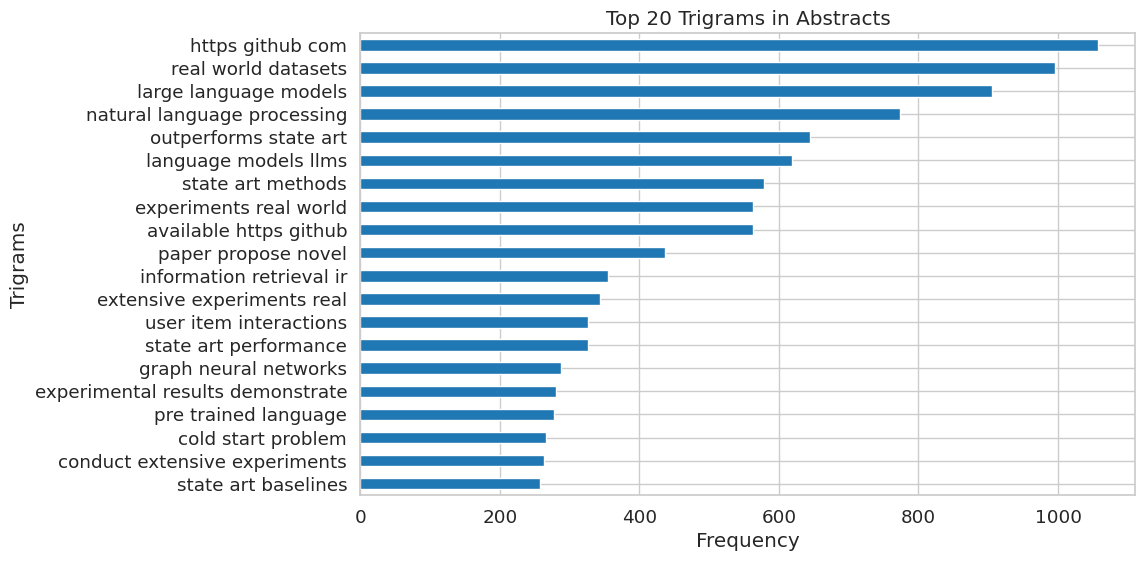

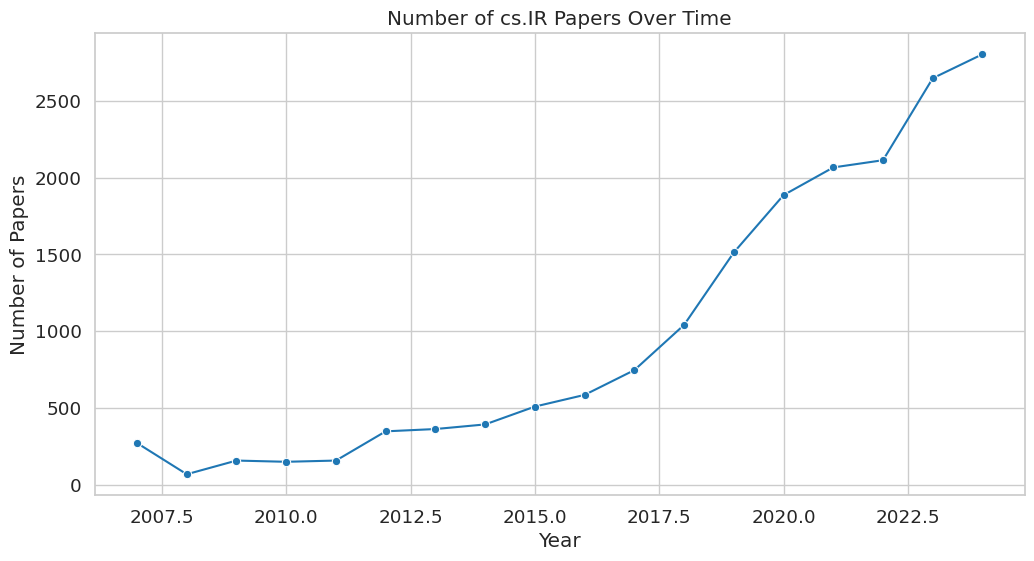

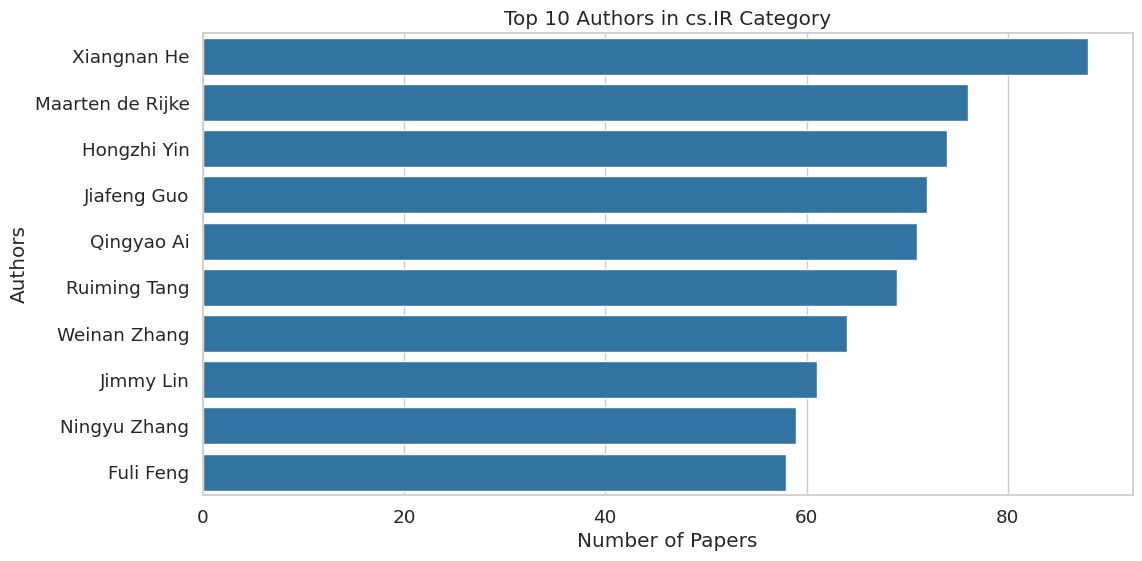

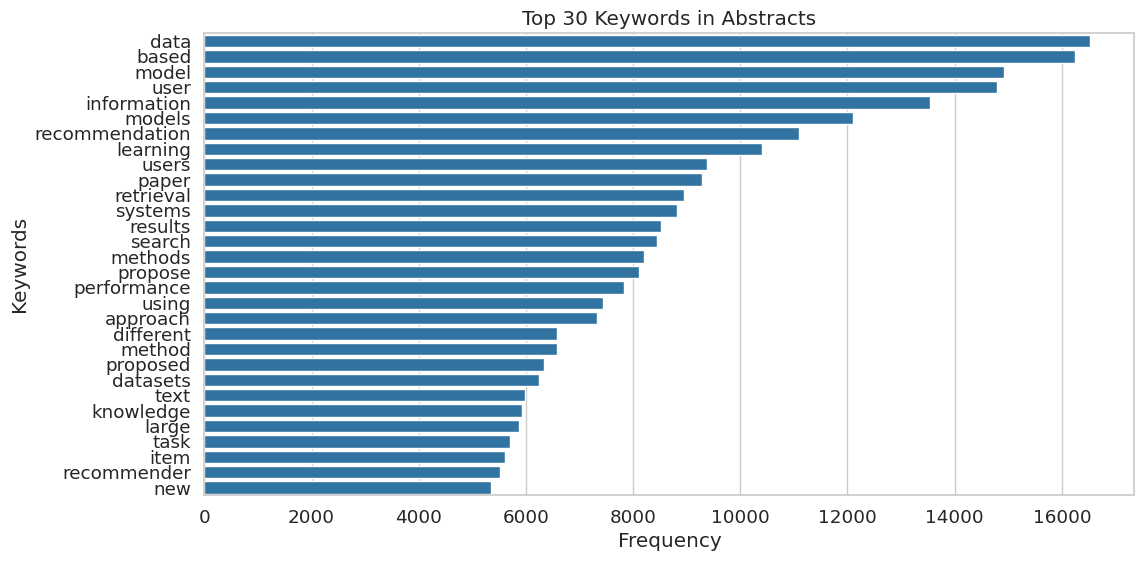

In [8]:
# Set Seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

def plot_top_categories(df, column_name, top_n=10, title='Top Categories',
                        xlabel='Number of Items', ylabel='Categories'):
    """
    Plots the top categories in IR.

    """
    top_categories = df[column_name].value_counts().head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_categories.values, y=top_categories.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_distribution(data, title, xlabel, ylabel, bins=30, kde=True):
    """
    Plots the distribution of wordcount in abstract.

    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_ngrams(ngrams, title, xlabel, ylabel):
    """
    Plots the frequency of N-grams.

    """
    plt.figure(figsize=(10, 6))
    ngrams.sort_values(ascending=True).plot(kind='barh')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def analyze_ngrams(df, ngram_range=(1, 1), top_n=20, column='abstract'):
    """
    Analyzes and returns the top N N-grams from abstract column.

    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(df[column].dropna())
    ngrams = pd.Series(X.toarray().sum(axis=0),
                       index=vectorizer.get_feature_names_out())
    top_ngrams = ngrams.sort_values(ascending=False).head(top_n)
    return top_ngrams

def plot_papers_per_year(df, date_column='update_date',
                         title='Number of cs.IR Papers Over Time'):
    """
    Plots the number of papers published per year.

    """
    df[date_column] = pd.to_datetime(df[date_column])
    df['year'] = df[date_column].dt.year
    papers_per_year = df['year'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=papers_per_year.index, y=papers_per_year.values, marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.show()

def plot_top_authors(df, author_column='authors',
                     top_n=10, title='Top Authors in cs.IR Category'):
    """
    Plots the top authors based on the number of papers.

    """
    top_authors = (
        df[author_column].str.split(', ',
        expand=True).stack().value_counts().head(top_n)
        )

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_authors.values, y=top_authors.index)
    plt.title(title)
    plt.xlabel('Number of Papers')
    plt.ylabel('Authors')
    plt.show()

def plot_top_keywords(df, text_column='abstract', top_n=30,
                      title='Top Keywords in Abstracts'):
    """
    Analyzes and plots the top keywords from abstract column

    """
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(df[text_column].dropna())
    keywords = dict(zip(vectorizer.get_feature_names_out(),
                        X.toarray().sum(axis=0)))
    sorted_keywords = dict(sorted(keywords.items(),
                                  key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(sorted_keywords.values()),
                y=list(sorted_keywords.keys()))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Keywords')
    plt.show()

def plot_all(df):
    """
    Performs data analysis and
    generates various plots.

    """
    # Plot top categories
    plot_top_categories(df, column_name='categories', top_n=10,
                        title='Top 10 Categories', xlabel='Number of Papers',
                        ylabel='Categories')

    # Add a new column for abstract word count
    df['abstract_word_count'] = (
                      df['abstract'].apply(lambda x: len(str(x).split()))
                      )

    # Plot distribution of word counts in abstracts
    plot_distribution(df['abstract_word_count'],
                      title='Distribution of Word Count in Abstracts',
                      xlabel='Word Count', ylabel='Frequency')

    # Plot unigrams
    unigrams = analyze_ngrams(df, ngram_range=(1, 1), top_n=20,
                              column='abstract')
    plot_ngrams(unigrams, title='Top 20 Unigrams in Abstracts',
                xlabel='Frequency', ylabel='Unigrams')

    # Plot bigrams
    bigrams = analyze_ngrams(df, ngram_range=(2, 2), top_n=20,
                             column='abstract')
    plot_ngrams(bigrams, title='Top 20 Bigrams in Abstracts',
                xlabel='Frequency', ylabel='Bigrams')

    # Plot trigrams
    trigrams = analyze_ngrams(df, ngram_range=(3, 3), top_n=20,
                              column='abstract')
    plot_ngrams(trigrams, title='Top 20 Trigrams in Abstracts',
                xlabel='Frequency', ylabel='Trigrams')

    # Plot count of papers published per year
    plot_papers_per_year(df, date_column='update_date',
                         title='Number of cs.IR Papers Over Time')

    # Plot top authors
    plot_top_authors(df, author_column='authors', top_n=10,
                     title='Top 10 Authors in cs.IR Category')

    # Analyze and plot top keywords
    plot_top_keywords(df, text_column='abstract', top_n=30,
                      title='Top 30 Keywords in Abstracts')

plot_all(df_ir)

#PREPROCESSING

##Handling the Missing Columns

In [9]:
# Clean and prepare the DataFrame by:
# - Filling missing values in the 'comments' column with 'No comments'
# - Dropping the 'report-no' and 'abstract_word_count' columns
#   as they are unnecessary

df_ir_cleaned = (
    df_ir
    .assign(comments=lambda x: x['comments'].fillna('No comments'))
    .drop(columns=['report-no', 'abstract_word_count'])
)

,id,submitter,authors,title,comments,journal-ref,doi,categories,license,abstract,versions,update_date,authors_parsed,year
0,0704.1158,Bernardo Huberman,Fang Wu and Bernardo A. Huberman,Novelty and Collective Attention,No comments,None,10.1073/pnas.0704916104,cs.CY cs.IR physics.soc-ph,None,The subject of collective attention is centr...,"[{'version': 'v1', 'created': 'Mon, 9 Apr 2007...",2009-11-13,"[[Wu, Fang, ], [Huberman, Bernardo A., ]]",2009
1,0704.1676,Kristina Lerman,"Kristina Lerman, Anon Plangprasopchok and Chio...",Personalizing Image Search Results on Flickr,"12 pages, submitted to AAAI07 workshop on Inte...",None,None,cs.IR cs.AI cs.CY cs.DL cs.HC,None,The social media site Flickr allows users to...,"[{'version': 'v1', 'created': 'Thu, 12 Apr 200...",2007-05-23,"[[Lerman, Kristina, ], [Plangprasopchok, Anon,...",2007
2,0704.2902,Stefan Pohl,"Stefan Pohl, Filip Radlinski and Thorsten Joac...",Recommending Related Papers Based on Digital L...,"2 pages, 3 postscript figures, to appear in pr...",None,None,cs.DL cs.IR,None,An important goal for digital libraries is t...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ], [Radlinski, Filip, ], [Joac...",2007
3,0704.2963,Stefan Pohl,Stefan Pohl,Using Access Data for Paper Recommendations on...,"73 pages, 31 figures, Master's Thesis",None,None,cs.DL cs.IR,None,This thesis investigates in the use of acces...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ]]",2007
4,0704.3316,Ciro Cattuto,"Ciro Cattuto, Andrea Baldassarri, Vito D. P. S...",Vocabulary growth in collaborative tagging sys...,"6 pages, 7 figures",None,None,cs.IR cond-mat.stat-mech cs.CY physics.data-an,None,We analyze a large-scale snapshot of del.ici...,"[{'version': 'v1', 'created': 'Wed, 25 Apr 200...",2007-05-23,"[[Cattuto, Ciro, ], [Baldassarri, Andrea, ], [...",2007


##Text Preprocessing: Cleaning Abstracts for Analysis

In [10]:
# Define a set of English stop words to be removed during text preprocessing
stop_words = set(stopwords.words('english'))

# Define a function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove all non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    # Remove stop words and join the remaining words back into a single string
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the text preprocessing function to the 'abstract' column
# and create a new column 'cleaned_abstract' in the DataFrame
df_ir_cleaned['cleaned_abstract'] = (
            df_ir_cleaned['abstract'].apply(preprocess_text))

# Drop the original 'abstract' column as it is no longer needed
df_ir_modified = df_ir_cleaned.drop(columns=['abstract'])

# Display the first few rows of the modified DataFrame to verify the changes
df_ir_modified.head()


,id,submitter,authors,title,comments,journal-ref,doi,categories,license,versions,update_date,authors_parsed,year,cleaned_abstract
0,0704.1158,Bernardo Huberman,Fang Wu and Bernardo A. Huberman,Novelty and Collective Attention,No comments,None,10.1073/pnas.0704916104,cs.CY cs.IR physics.soc-ph,None,"[{'version': 'v1', 'created': 'Mon, 9 Apr 2007...",2009-11-13,"[[Wu, Fang, ], [Huberman, Bernardo A., ]]",2009,subject collective attention central informati...
1,0704.1676,Kristina Lerman,"Kristina Lerman, Anon Plangprasopchok and Chio...",Personalizing Image Search Results on Flickr,"12 pages, submitted to AAAI07 workshop on Inte...",None,None,cs.IR cs.AI cs.CY cs.DL cs.HC,None,"[{'version': 'v1', 'created': 'Thu, 12 Apr 200...",2007-05-23,"[[Lerman, Kristina, ], [Plangprasopchok, Anon,...",2007,social media site flickr allows users upload p...
2,0704.2902,Stefan Pohl,"Stefan Pohl, Filip Radlinski and Thorsten Joac...",Recommending Related Papers Based on Digital L...,"2 pages, 3 postscript figures, to appear in pr...",None,None,cs.DL cs.IR,None,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ], [Radlinski, Filip, ], [Joac...",2007,important goal digital libraries enable resear...
3,0704.2963,Stefan Pohl,Stefan Pohl,Using Access Data for Paper Recommendations on...,"73 pages, 31 figures, Master's Thesis",None,None,cs.DL cs.IR,None,"[{'version': 'v1', 'created': 'Mon, 23 Apr 200...",2007-05-23,"[[Pohl, Stefan, ]]",2007,thesis investigates use access log data source...
4,0704.3316,Ciro Cattuto,"Ciro Cattuto, Andrea Baldassarri, Vito D. P. S...",Vocabulary growth in collaborative tagging sys...,"6 pages, 7 figures",None,None,cs.IR cond-mat.stat-mech cs.CY physics.data-an,None,"[{'version': 'v1', 'created': 'Wed, 25 Apr 200...",2007-05-23,"[[Cattuto, Ciro, ], [Baldassarri, Andrea, ], [...",2007,analyze large scale snapshot del icio us inves...


#Constructing NLP Models: Custom, Fine-Tuned, and Pretrained Approaches

##Accessing and Setting Up Hugging Face API Key from Google Colab Secrets

In [11]:
# Access the Hugging Face API key stored as a secret in Google Colab
hf_api_key = userdata.get('HF_TOKEN')

if hf_api_key:
    # Set the API key as an environment variable for Hugging Face
    os.environ['HUGGINGFACE_HUB_TOKEN'] = hf_api_key
else:
    raise ValueError(

"Hugging Face API token not found. Please set the 'HF_TOKEN' secret in Colab.")



##Building and Training a Custom GPT-2 Model from Scratch

###Custom Configuration and Initialization of a GPT-2 Model

In [12]:
# Custom configuration for the GPT-2 model
# - n_embd: Size of the embedding dimension
# - n_layer: Number of transformer layers
# - n_head: Number of attention heads in each transformer layer
# - dropout: Dropout rate for regularization
scr_config = GPT2Config(n_embd=1024, n_layer=16, n_head=16, dropout=0.3)

# Set a manual seed for reproducibility before model initialization
torch.manual_seed(42)

# Initialize the GPT-2 model with the custom configuration
scr_model = GPT2LMHeadModel(scr_config)

# Load the GPT-2 tokenizer
scr_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token to the EOS token (end of sequence token)
scr_tokenizer.pad_token = scr_tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

###Tokenizing and Preparing Input Data for the Custom GPT-2 Model

In [13]:
# Tokenize and Prepare Input Data for the Custom GPT-2 Model

# Tokenize the 'cleaned_abstract' column from the DataFrame
# - Converts the text into tokens suitable for the GPT-2 model
# - Truncates or pads the sequences to a maximum length of 256 tokens
# - Returns the results as PyTorch tensors
tokenized_inputs_scr = scr_tokenizer(
    df_ir_modified['cleaned_abstract'].tolist(),
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

# Extract the input IDs tensor from the tokenized inputs
# - input_ids represent the tokenized text as integer indices
input_ids_scr = tokenized_inputs_scr['input_ids']

# Extract the attention mask tensor from the tokenized inputs
# - attention_mask indicates which tokens should be attended to (1)
#  or ignored (0) by the model
attention_mask_scr = tokenized_inputs_scr['attention_mask']


###Verifying the Shapes of Tokenized Inputs and Attention Masks

In [14]:
# Print the shape of the input_ids tensor
# - Should match the batch size and max_length
print(f"Shape of input_ids: {input_ids_scr.shape}")

# Print the shape of the attention_mask tensor
# - Should match the batch size and max_length
print(f"Shape of attention_mask: {attention_mask_scr.shape}")


Shape of input_ids: torch.Size([17841, 256])
Shape of attention_mask: torch.Size([17841, 256])


###Creating and Preparing the TensorDataset

In [15]:
# Create a TensorDataset using the input_ids and attention_mask
# The labels for training are also the input_ids
dataset_scr = TensorDataset(input_ids_scr, attention_mask_scr, input_ids_scr)

# Determine the size of the training set (80% of the total dataset)
train_size = int(0.8 * len(dataset_scr))

# The remaining 20% of the dataset will be used for testing
test_size = len(dataset_scr) - train_size


###Splitting the Dataset and Creating Data Loaders

In [16]:
# Set a manual seed for reproducibility of random operations
torch.manual_seed(42)

# Randomly split the TensorDataset into training and testing sets
train_dataset_scr, test_dataset_scr = torch.utils.data.random_split(
    dataset_scr, [train_size, test_size]
)

# Set the seed again before creating the DataLoaders
torch.manual_seed(42)

# Create DataLoader for the training set
# - RandomSampler ensures that the training data is shuffled each epoch
# - batch_size is set to 32, meaning the model will process 32 samples at a time
train_loader_scr = DataLoader(
    train_dataset_scr,
    sampler=RandomSampler(train_dataset_scr),
    batch_size=32
)

# Create DataLoader for the testing set
# - SequentialSampler ensures that the testing data is processed in order
#   without shuffling
# - batch_size is set to 32, allowing for efficient batch processing during
#   evaluation
test_loader_scr = DataLoader(
    test_dataset_scr,
    sampler=SequentialSampler(test_dataset_scr),
    batch_size=32
)


###Configuring the Training Environment for the Custom GPT-2 Model

In [17]:
# Set up the device to use GPU if available; otherwise, fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the custom GPT-2 model to the selected device
scr_model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-15): 16 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

###Setting Up the Optimizer, and Learning Rate Scheduler

In [18]:
# Set up the optimizer
# - AdamW is an improved version of Adam with weight decay,
#   which helps prevent overfitting
# - The optimizer updates the model parameters during training based on the
#   computed gradients
optimizer = torch.optim.AdamW(scr_model.parameters(), lr=6e-5)

# Calculate the total number of training steps
# - This is based on the number of batches per epoch (len(train_loader_scr))
#   and the number of epochs (10)
total_steps = len(train_loader_scr) * 10

# Set up the learning rate scheduler
# - The scheduler adjusts the learning rate during training
# - Linear schedule with warm-up: the learning rate increases linearly for the
#   first 10% of the steps, then decreases linearly
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    # Warm up for the first 10% of the total steps
    num_warmup_steps=int(0.1 * total_steps),
    # Total number of training steps
    num_training_steps=total_steps
)


###Implementing and Initializing Early Stopping for Training

In [19]:
# Implementing and Initializing Early Stopping for Training

# Define the EarlyStopping class
# - Early stopping is a regularization technique to prevent overfitting
# - It monitors the validation loss and stops training if the loss doesn't
#   improve after a set number of epochs (patience)
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        # Number of epochs to wait before stopping if no improvement
        self.patience = patience
        # Minimum change in the monitored quantity to qualify as an improvement
        self.delta = delta
        # Counter for the number of epochs without improvement
        self.counter = 0
        # Best validation loss encountered so far
        self.best_loss = None
        # Flag to indicate if training should be stopped
        self.early_stop = False

    # Method to check if training should be stopped
    def __call__(self, val_loss):
        # If best_loss hasn't been set yet, initialize it with the
        # current validation loss
        if self.best_loss is None:
            self.best_loss = val_loss
        # If the validation loss hasn't improved by more than delta,
        # increase the counter
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            # If the counter exceeds patience, set the early_stop flag to True
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # If the validation loss improves, reset the counter and
            # update best_loss
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping with a patience of 3 epochs and a delta of 0.01
early_stopping = EarlyStopping(patience=3, delta=0.01)


###Training Loop for the Custom GPT-2 Model

In [20]:
# Initialize lists to store the training and validation losses for each epoch
train_losses_scratch = []
val_losses_scratch = []

# Loop over the 20 epochs
for epoch in range(20):
    scr_model.train()  # Set the model to training mode
    epoch_train_loss = 0  # Initialize the epoch's training loss

    # Iterate over batches of data from the training DataLoader
    for batch in train_loader_scr:
        optimizer.zero_grad()# Reset the gradients from the previous step
        # Move input_ids to the selected device
        input_ids = batch[0].to(device)
        # Move attention_mask to the selected device
        attention_mask = batch[1].to(device)
        # Move labels (targets) to the selected device
        labels = batch[2].to(device)

        #compute the model's output and the loss
        outputs = scr_model(input_ids, attention_mask=attention_mask,
                            labels=labels)
        loss = outputs.loss

        # Backpropagate the loss and update the model's parameters
        loss.backward()

        # Perform an optimization step to update the model parameters
        optimizer.step()

        # Update the learning rate using the scheduler
        scheduler.step()

        # Accumulate the epoch's training loss
        epoch_train_loss += loss.item()


    # Calculate the average training loss for the epoch and store it
    avg_train_loss = epoch_train_loss / len(train_loader_scr)
    train_losses_scratch.append(avg_train_loss)

    # Set the model to evaluation mode
    scr_model.eval()
    epoch_val_loss = 0  # Initialize the epoch's validation loss

    # Disable gradient computation during validation for memory efficiency
    with torch.no_grad():
        # Iterate over batches of data from the validation DataLoader
        for batch in test_loader_scr:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            #compute the model's output and the loss
            outputs = scr_model(input_ids, attention_mask=attention_mask,
            labels=labels)
            loss = outputs.loss

            # Accumulate the epoch's validation loss
            epoch_val_loss += loss.item()

    # Calculate the average validation loss for the epoch
    avg_val_loss = epoch_val_loss / len(test_loader_scr)
    val_losses_scratch.append(avg_val_loss)

    # Print the training and validation loss for the current epoch
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f},"
          f"Validation Loss: {avg_val_loss:.4f}")

    # Check if early stopping should be triggered
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break # Exit the training loop if early stopping is triggered


Epoch 1, Training Loss: 4.5053,Validation Loss: 3.7262
Epoch 2, Training Loss: 3.5033,Validation Loss: 3.2925
Epoch 3, Training Loss: 3.1891,Validation Loss: 3.1197
Epoch 4, Training Loss: 3.0203,Validation Loss: 3.0262
Epoch 5, Training Loss: 2.8983,Validation Loss: 2.9633
Epoch 6, Training Loss: 2.7965,Validation Loss: 2.9188
Epoch 7, Training Loss: 2.7053,Validation Loss: 2.8899
Epoch 8, Training Loss: 2.6226,Validation Loss: 2.8690
Epoch 9, Training Loss: 2.5479,Validation Loss: 2.8556
Epoch 10, Training Loss: 2.4878,Validation Loss: 2.8521
Epoch 11, Training Loss: 2.4590,Validation Loss: 2.8521
Epoch 12, Training Loss: 2.4593,Validation Loss: 2.8521
Early stopping


###Evaluating the Custom GPT-2 Model

In [21]:
# Set the model to evaluation mode
scr_model.eval()

# Initialize a variable to accumulate the test loss
test_loss_scratch = 0

# Disable gradient calculation
with torch.no_grad():
    # Loop over batches in the test DataLoader
    for batch in test_loader_scr:
        # Move input_ids, attention_mask, and labels to the selected device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Perform a forward pass through the model
        outputs = scr_model(input_ids, attention_mask=attention_mask,
                            labels=labels)
        loss = outputs.loss
        test_loss_scratch += loss.item()

# Calculate the average test loss over all batches
average_test_loss_scratch = test_loss_scratch / len(test_loader_scr)

# Print the average test loss
print(f'Average Test Loss (Scratch Model): {average_test_loss_scratch:.4f}')


Average Test Loss (Scratch Model): 2.8521


###Plotting the Training and Validation Loss Curves for the Custom GPT-2 Model

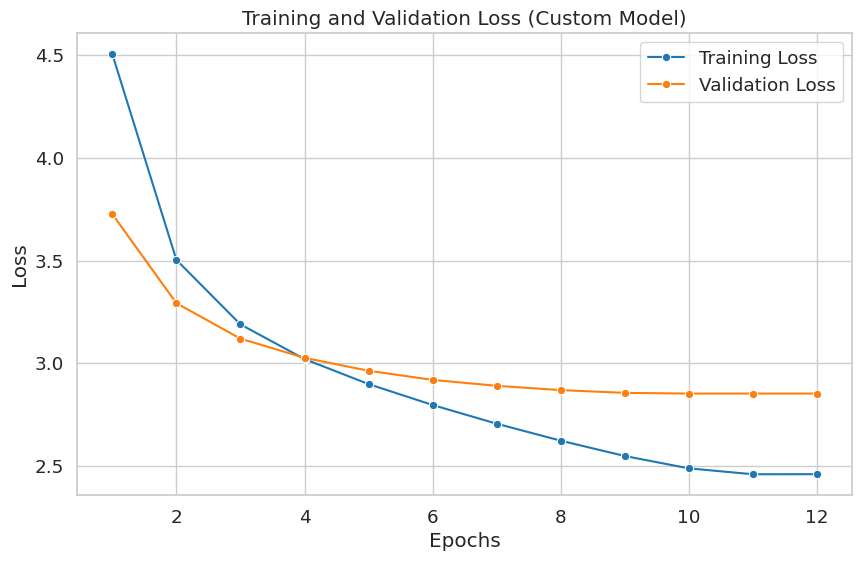

In [22]:
# Create a new figure for the plot with a specified size
plt.figure(figsize=(10, 6))

# Plot the training loss curve
sns.lineplot(x=range(1, len(train_losses_scratch) + 1),
             y=train_losses_scratch,
             label='Training Loss',
             marker='o')

# Plot the validation loss curve
sns.lineplot(x=range(1, len(val_losses_scratch) + 1),
             y=val_losses_scratch,
             label='Validation Loss',
             marker='o')
plt.title('Training and Validation Loss (Custom Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#Fine-Tuning a Pre-Trained GPT-2 Model

##Dataset Preparation and Splitting

In [23]:
# Set a manual seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Ensure deterministic behavior in CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Convert the data to a Hugging Face Dataset
# - The Dataset class is used to handle data more efficiently and is compatible
#   with the Hugging Face Trainer API.
# - Here, we are converting a Pandas DataFrame (df_ir) into a Dataset object.
dataset = Dataset.from_pandas(df_ir)

# Split the dataset into training and evaluation sets
split_dataset = dataset.train_test_split(test_size=0.2)

# Print the number of samples in the training and test sets
print(f"Total number of samples: {len(split_dataset['train'])} train,"
      f"{len(split_dataset['test'])} test")


Total number of samples: 14272 train,3569 test


##Initializing the GPT-2 Tokenizer and Model for Fine-Tuning

In [24]:
# Initializing the GPT-2 Tokenizer and Model for Fine-Tuning

# Load the pre-trained GPT-2 tokenizer from Hugging Face
# - This tokenizer will convert text into tokens that the GPT-2 model can
#   understand.
# - The 'from_pretrained' method loads the tokenizer that matches the
#   pre-trained GPT-2 model.
tokenizer_ft = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token to the EOS (End of Sequence) token
# - GPT-2 does not have a padding token by default, so we set it to the EOS token.
# - This is necessary for padding sequences during training, ensuring that
#   all input sequences are the same length.
tokenizer_ft.pad_token = tokenizer_ft.eos_token


##Tokenization Function for Preparing Data for Fine-Tuning

In [25]:
def tokenize_function(examples):
    # Tokenize the input text from the 'abstract' field
    # - 'padding="max_length"' pads sequences to the maximum length specified
    # - 'truncation=True' ensures that sequences longer than the maximum length
    #   are truncated to fit within the limit
    inputs = tokenizer_ft(examples['abstract'], padding='max_length',
                          truncation=True)

    # Create the labels for the model by copying the input IDs
    # - In language modeling tasks, the input tokens are often used as the
    #   target labels
    # - The model learns to predict the next token in the sequence, so the labels
    #   are the same as the input IDs
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs


In [26]:
# Apply the tokenize_function to the entire dataset
# - The map function applies the tokenization to each example in the dataset.
# - batched=True indicates that the tokenization is applied to batches of
#   examples at once,
#   which speeds up the process compared to applying it to one example at a time.
tokenized_datasets_ft = split_dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/14272 [00:00<?, ? examples/s]

Map:   0%|          | 0/3569 [00:00<?, ? examples/s]

##Initializing the Fine-Tuned GPT-2 Model and Setting Up Training Parameters

In [27]:
# Load the pre-trained GPT-2 model for fine-tuning
# - This loads the base GPT-2 model from Hugging Face,
#   which you will fine-tune on your specific dataset.
model_ft = GPT2LMHeadModel.from_pretrained('gpt2')

# Resize the token embeddings to match the tokenizer's vocabulary size
# - If you added new tokens or modified the tokenizer, this ensures that the
#   model's embeddings
#   are resized to handle the updated vocabulary.
model_ft.resize_token_embeddings(len(tokenizer_ft))

# Define the training arguments for fine-tuning
training_args_ft = TrainingArguments(
    output_dir='./results_ft', # Directory to save model checkpoints and results
    eval_strategy="epoch",     # Evaluation is done at the end of each epoch
    logging_dir='./logs_ft',   # Directory to save training logs
    logging_steps=10,          # Log training progress every 10 steps
    learning_rate=2e-5,        # Learning rate for the optimizer
    per_device_train_batch_size=8, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    num_train_epochs=3, # Number of epochs
    weight_decay=0.01, # Weight decay to prevent overfitting
    save_total_limit=2, # Limit the total number of saved checkpoints
    load_best_model_at_end=True, # Load the model with the best evaluation loss
    metric_for_best_model="eval_loss", # Use eval loss to determine the best model
    save_strategy="epoch" # Save checkpoints at the end of every epoch
)

# Initialize the Trainer for fine-tuning the model
# that handles the training loop, evaluation, and model saving.
trainer_ft = Trainer(
    # The GPT-2 model to be fine-tuned
    model=model_ft,
    # Training arguments defined above
    args=training_args_ft,
    # The tokenized training dataset
    train_dataset=tokenized_datasets_ft['train'],
    # The tokenized evaluation (test) dataset
    eval_dataset=tokenized_datasets_ft['test'],
    # Early stopping callback to prevent overfitting
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# This starts the training process using the Trainer.
trainer_ft.train()


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.762900,0.726206
2,0.730800,0.712976
3,0.748300,0.709583


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=5352, training_loss=0.7636489196386751, metrics={'train_runtime': 2985.1768, 'train_samples_per_second': 14.343, 'train_steps_per_second': 1.793, 'total_flos': 2.2374959284224e+16, 'train_loss': 0.7636489196386751, 'epoch': 3.0})

##Evaluating the Fine-tuned GPT-2 Model on the Test Dataset

In [28]:
# Evaluate the fine-tuned GPT-2 model using the test dataset
# - This method uses the evaluation dataset that was specified during the Trainer
#   initialization.
eval_results_ft = trainer_ft.evaluate()

# Print the evaluation results
# - The results typically include metrics such as evaluation loss,
#   which gives an indication
#   of how well the model is performing on new data.
print(f"Evaluation Results (Fine-Tuned GPT-2 Model): {eval_results_ft}")


Evaluation Results (Fine-Tuned GPT-2 Model): {'eval_loss': 0.7095826268196106, 'eval_runtime': 77.5387, 'eval_samples_per_second': 46.029, 'eval_steps_per_second': 5.765, 'epoch': 3.0}


## Plotting Training and Validation Losses Across Epochs

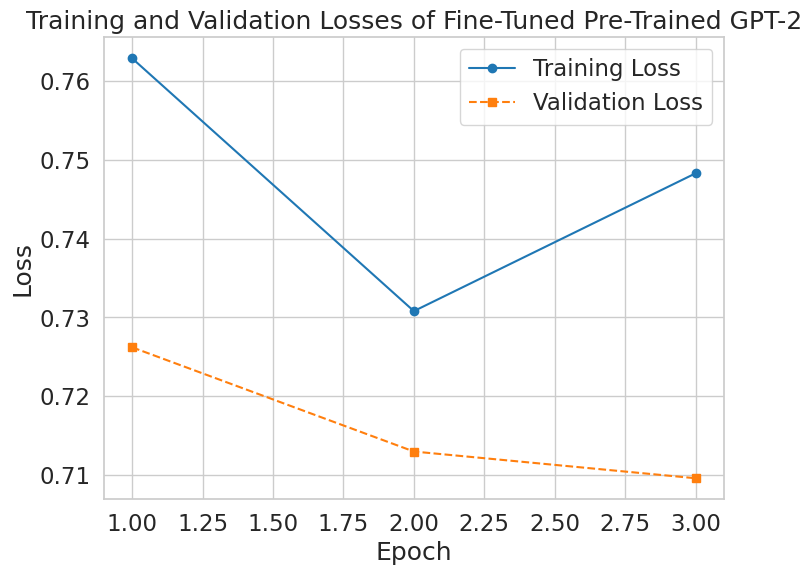

In [29]:
# - epochs: A list of epoch numbers (1, 2, 3) representing the training
#   iterations
# - training_loss: A list of training loss values corresponding to each epoch
# - validation_loss: A list of validation loss values corresponding to each
#   epoch
epochs = [1, 2, 3]
training_loss = [0.762900, 0.730800, 0.748300]
validation_loss = [0.726208, 0.712976, 0.709583]

# Plot the training and validation loss data
plt.figure(figsize=(8, 6))

# Plot the training loss curve
plt.plot(epochs, training_loss, label='Training Loss', marker='o',
         linestyle='-')

# Plot the validation loss curve
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s',
         linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses of Fine-Tuned Pre-Trained GPT-2')
plt.legend()
plt.show()


#Using a Pre-Trained BERT2BERT Model

In [30]:
# The BertTokenizer is used to tokenize the input text, making it compatible
# with the BERT2BERT model.
# The specific pre-trained model 'patrickvonplaten/bert2bert_cnn_daily_mail'
# is designed for tasks like text summarization.
bert2bert_tokenizer = BertTokenizer.from_pretrained(
    'patrickvonplaten/bert2bert_cnn_daily_mail'
    )

# Load the pre-trained BERT2BERT model using the EncoderDecoderModel class
# - This model is a sequence-to-sequence model where both the encoder and
#   decoder are based on BERT.
bert2bert_model = EncoderDecoderModel.from_pretrained(
    'patrickvonplaten/bert2bert_cnn_daily_mail'
)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

#Text Generation Using Different Models: Custom GPT-2, Fine-Tuned GPT-2, and Pre-Trained BERT2BERT

In [31]:
def generate_text(prompt, model, tokenizer, max_length=100,
                  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Generate text based on the given prompt using the specified model and tokenizer.

    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Tokenize the input prompt, converting it into a format the model can process
    inputs = tokenizer.encode(prompt, return_tensors='pt',
                              padding=True, truncation=True,
                              max_length=max_length).to(device)

    # Generate the output text from the model
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=max_length,  # Maximum length of the generated text
            num_return_sequences=1,  # Number of sequences to generate
            no_repeat_ngram_size=3,  # Prevent repetition of n-grams of this size
            pad_token_id=tokenizer.pad_token_id,  # ID for padding token
            eos_token_id=tokenizer.eos_token_id,  # ID for end-of-sequence token
            attention_mask=inputs.ne(tokenizer.pad_token_id),  # Mask padding tokens
            temperature=0.8,  # Controls randomness in sampling
            top_k=50,  # Use top-k sampling strategy
            top_p=0.9,  # Use nucleus sampling strategy (top-p)
            do_sample=True  # Enable sampling instead of greedy decoding
        )

    # Decode the generated sequence of token IDs back into text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text

# Sample prompt for text generation
sample_prompt = (
    "Sequential recommender systems are an important and demanded area "
    "of research"
)

# Generate text with the Custom-built model
generated_text_scratch = generate_text(sample_prompt, scr_model, scr_tokenizer)

# Generate text with the fine-tuned GPT-2 model
generated_text_finetuned = generate_text(sample_prompt, model_ft, tokenizer_ft)

# Generate text with the pretrained BERT2BERT model
generated_text_pretrained = generate_text(sample_prompt, bert2bert_model,
                                          bert2bert_tokenizer)

# Print the generated texts
print("Generated Text from Custom Model:", generated_text_scratch)
print("Generated Text from Fine-tuned GPT-2 Model:", generated_text_finetuned)
print("Generated Text from Pretrained BERT2BERT Model:",
      generated_text_pretrained)

Generated Text from Custom Model: Sequential recommender systems are an important and demanded area of research development recommender system rs research efforts made focused recommender models proposed literature literature using state art results obtained topology based models developed using recommender model user side effects data research area research paper recommendation problem proposed recommender framework based recommender algorithms literature two different algorithms collaborative filtering techniques model based models collaborative filtering methods proposed literature review based recommendation techniques proposed approach based recommending collaborative filtering cf model developed literature results presented obtained results show proposed algorithms outper
Generated Text from Fine-tuned GPT-2 Model: Sequential recommender systems are an important and demanded area of research in
human-computer interaction. To overcome the limitations of sequential recommender
syst

#Results and Evaluations

##Evaluating Generated Text Using ROUGE Scores

In [32]:
# Initialize ROUGE scorer
# - 'rouge1' and 'rougeL' are selected as the ROUGE metrics to be calculated.
# - use_stemmer=True applies stemming to the text before scoring, which helps in
#   improving the accuracy of the ROUGE score by reducing words to their root form.
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Reference text to compare against the generated text
reference_text = (
    "Sequential recommender systems are an important and demanded area of research. "
    "Such systems aim to use the order of interactions in a user's history to predict "
    "future interactions. The premise is that the order of interactions and sequential "
    "patterns play an essential role. Therefore, it is crucial to use datasets that "
    "exhibit a sequential structure to evaluate sequential recommenders properly."
)

# Calculate ROUGE scores for each model's generated text
# - This compares the reference text with the generated text from each model
rouge_scores_scratch = rouge.score(reference_text, generated_text_scratch)
rouge_scores_finetuned = rouge.score(reference_text, generated_text_finetuned)
rouge_scores_pretrained = rouge.score(reference_text, generated_text_pretrained)

# Print ROUGE-1 and ROUGE-L scores for the Custom Model
print("Custom Model ROUGE-1:", rouge_scores_scratch['rouge1'])
print("Custom Model ROUGE-L:", rouge_scores_scratch['rougeL'])

# Print ROUGE-1 and ROUGE-L scores for the Fine-Tuned GPT-2 Model
print("Fine-Tuned GPT-2 ROUGE-1:", rouge_scores_finetuned['rouge1'])
print("Fine-Tuned GPT-2 ROUGE-L:", rouge_scores_finetuned['rougeL'])

# Print ROUGE-1 and ROUGE-L scores for the Pretrained BERT2BERT Model
print("Pretrained BERT2BERT ROUGE-1:", rouge_scores_pretrained['rouge1'])
print("Pretrained BERT2BERT ROUGE-L:", rouge_scores_pretrained['rougeL'])


Custom Model ROUGE-1: Score(precision=0.1797752808988764, recall=0.26229508196721313, fmeasure=0.21333333333333332)
Custom Model ROUGE-L: Score(precision=0.16853932584269662, recall=0.2459016393442623, fmeasure=0.19999999999999998)
Fine-Tuned GPT-2 ROUGE-1: Score(precision=0.4691358024691358, recall=0.6229508196721312, fmeasure=0.5352112676056338)
Fine-Tuned GPT-2 ROUGE-L: Score(precision=0.2962962962962963, recall=0.39344262295081966, fmeasure=0.3380281690140845)
Pretrained BERT2BERT ROUGE-1: Score(precision=0.5111111111111111, recall=0.3770491803278688, fmeasure=0.43396226415094336)
Pretrained BERT2BERT ROUGE-L: Score(precision=0.35555555555555557, recall=0.26229508196721313, fmeasure=0.30188679245283023)


In [33]:
# Combine the scores into a list of dictionaries for better visualization
data_rogue = [
    {
        "Model": "Custom Model",
        "Metric": "ROUGE-1",
        "Precision": rouge_scores_scratch['rouge1'].precision,
        "Recall": rouge_scores_scratch['rouge1'].recall,
        "F1-Score": rouge_scores_scratch['rouge1'].fmeasure
    },
    {
        "Model": "Custom Model",
        "Metric": "ROUGE-L",
        "Precision": rouge_scores_scratch['rougeL'].precision,
        "Recall": rouge_scores_scratch['rougeL'].recall,
        "F1-Score": rouge_scores_scratch['rougeL'].fmeasure
    },
    {
        "Model": "Fine-Tuned GPT-2",
        "Metric": "ROUGE-1",
        "Precision": rouge_scores_finetuned['rouge1'].precision,
        "Recall": rouge_scores_finetuned['rouge1'].recall,
        "F1-Score": rouge_scores_finetuned['rouge1'].fmeasure
    },
    {
        "Model": "Fine-Tuned GPT-2",
        "Metric": "ROUGE-L",
        "Precision": rouge_scores_finetuned['rougeL'].precision,
        "Recall": rouge_scores_finetuned['rougeL'].recall,
        "F1-Score": rouge_scores_finetuned['rougeL'].fmeasure
    },
    {
        "Model": "Pretrained BERT2BERT",
        "Metric": "ROUGE-1",
        "Precision": rouge_scores_pretrained['rouge1'].precision,
        "Recall": rouge_scores_pretrained['rouge1'].recall,
        "F1-Score": rouge_scores_pretrained['rouge1'].fmeasure
    },
    {
        "Model": "Pretrained BERT2BERT",
        "Metric": "ROUGE-L",
        "Precision": rouge_scores_pretrained['rougeL'].precision,
        "Recall": rouge_scores_pretrained['rougeL'].recall,
        "F1-Score": rouge_scores_pretrained['rougeL'].fmeasure
    }
]

table = tabulate(data_rogue, headers="keys", tablefmt="grid")
print(table)


+----------------------+----------+-------------+----------+------------+
| Model                | Metric   |   Precision |   Recall |   F1-Score |
+======================+==========+=============+==========+============+
| Custom Model         | ROUGE-1  |    0.179775 | 0.262295 |   0.213333 |
+----------------------+----------+-------------+----------+------------+
| Custom Model         | ROUGE-L  |    0.168539 | 0.245902 |   0.2      |
+----------------------+----------+-------------+----------+------------+
| Fine-Tuned GPT-2     | ROUGE-1  |    0.469136 | 0.622951 |   0.535211 |
+----------------------+----------+-------------+----------+------------+
| Fine-Tuned GPT-2     | ROUGE-L  |    0.296296 | 0.393443 |   0.338028 |
+----------------------+----------+-------------+----------+------------+
| Pretrained BERT2BERT | ROUGE-1  |    0.511111 | 0.377049 |   0.433962 |
+----------------------+----------+-------------+----------+------------+
| Pretrained BERT2BERT | ROUGE-L  |   

##Plotting Comparison of ROUGE-1 and ROUGE-L Scores Across Models

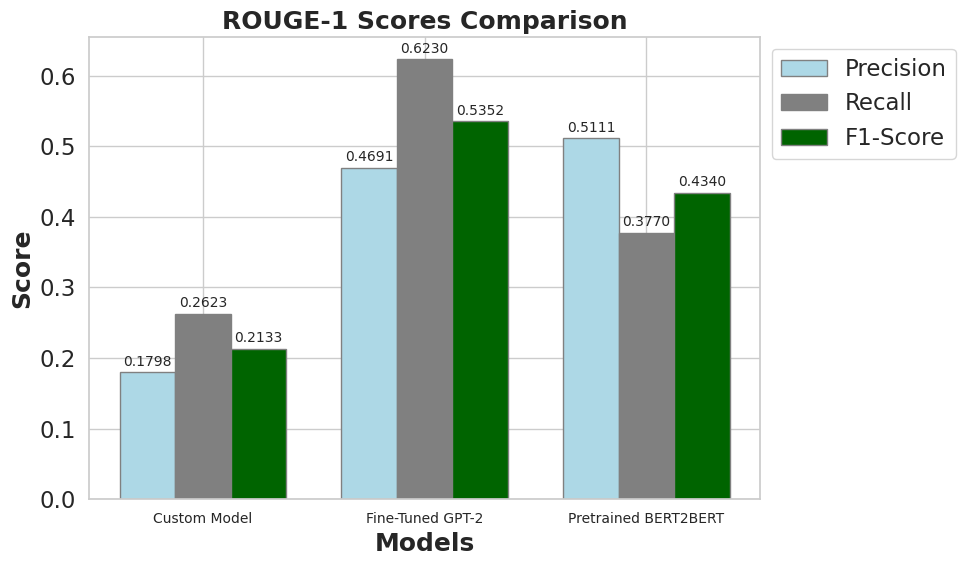

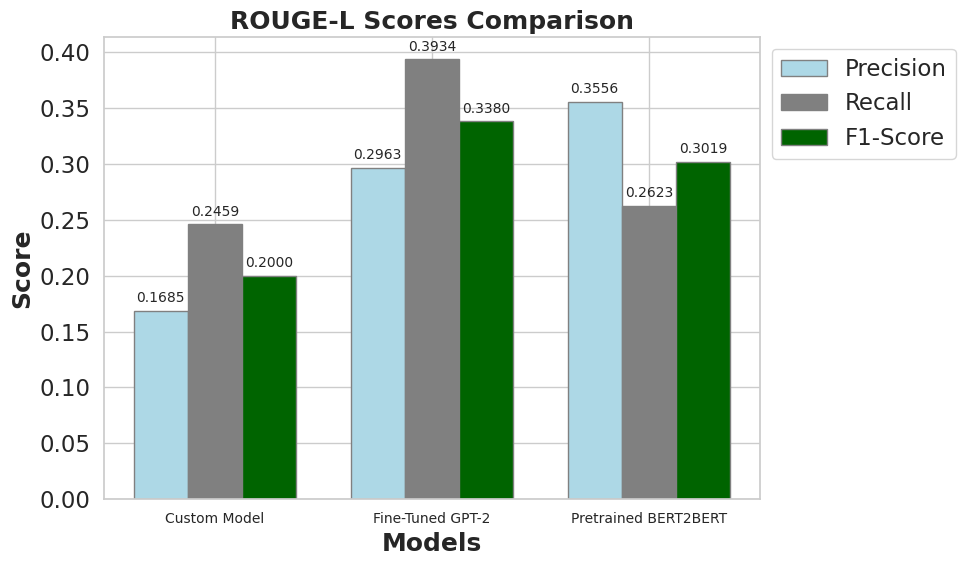

In [34]:
models = ["Custom Model", "Fine-Tuned GPT-2", "Pretrained BERT2BERT"]

# Data for ROUGE-1 scores
# - Precision, Recall, and F1-Score for each model's ROUGE-1 evaluation
precision_rouge1 = [
    rouge_scores_scratch['rouge1'].precision,
    rouge_scores_finetuned['rouge1'].precision,
    rouge_scores_pretrained['rouge1'].precision
]
recall_rouge1 = [
    rouge_scores_scratch['rouge1'].recall,
    rouge_scores_finetuned['rouge1'].recall,
    rouge_scores_pretrained['rouge1'].recall
]
f1_rouge1 = [
    rouge_scores_scratch['rouge1'].fmeasure,
    rouge_scores_finetuned['rouge1'].fmeasure,
    rouge_scores_pretrained['rouge1'].fmeasure
]

# Plotting ROUGE-1 scores
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 6))
plt.bar(
    r1, precision_rouge1, color='lightblue', width=bar_width,
    edgecolor='grey', label='Precision'
)
plt.bar(
    r2, recall_rouge1, color='grey', width=bar_width,
    edgecolor='grey', label='Recall'
)
plt.bar(
    r3, f1_rouge1, color='darkgreen', width=bar_width,
    edgecolor='grey', label='F1-Score'
)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('ROUGE-1 Scores Comparison', fontweight='bold')
plt.xticks(
    [r + bar_width for r in range(len(models))],
    models, fontsize=10
)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add the scores on top of the bars for ROUGE-1
for i in range(len(models)):
    plt.text(
        r1[i], precision_rouge1[i] + 0.005,
        f'{precision_rouge1[i]:.4f}', ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r2[i], recall_rouge1[i] + 0.005,
        f'{recall_rouge1[i]:.4f}', ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r3[i], f1_rouge1[i] + 0.005,
        f'{f1_rouge1[i]:.4f}', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

# Data for ROUGE-L scores
# - Precision, Recall, and F1-Score for each model's ROUGE-L evaluation
precision_rougeL = [
    rouge_scores_scratch['rougeL'].precision,
    rouge_scores_finetuned['rougeL'].precision,
    rouge_scores_pretrained['rougeL'].precision
]
recall_rougeL = [
    rouge_scores_scratch['rougeL'].recall,
    rouge_scores_finetuned['rougeL'].recall,
    rouge_scores_pretrained['rougeL'].recall
]
f1_rougeL = [
    rouge_scores_scratch['rougeL'].fmeasure,
    rouge_scores_finetuned['rougeL'].fmeasure,
    rouge_scores_pretrained['rougeL'].fmeasure
]

# Plotting ROUGE-L scores
plt.figure(figsize=(10, 6))
plt.bar(
    r1, precision_rougeL, color='lightblue', width=bar_width,
    edgecolor='grey', label='Precision'
)
plt.bar(
    r2, recall_rougeL, color='grey', width=bar_width,
    edgecolor='grey', label='Recall'
)
plt.bar(
    r3, f1_rougeL, color='darkgreen', width=bar_width,
    edgecolor='grey', label='F1-Score'
)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('ROUGE-L Scores Comparison', fontweight='bold')
plt.xticks(
    [r + bar_width for r in range(len(models))],
    models, fontsize=10
)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add the scores on top of the bars for ROUGE-L
for i in range(len(models)):
    plt.text(
        r1[i], precision_rougeL[i] + 0.005,
        f'{precision_rougeL[i]:.4f}', ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r2[i], recall_rougeL[i] + 0.005,
        f'{recall_rougeL[i]:.4f}', ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r3[i], f1_rougeL[i] + 0.005,
        f'{f1_rougeL[i]:.4f}', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


##Calculating Perplexity of the Custom Model on the Test Dataset

In [35]:
# Function to calculate perplexity
def calculate_perplexity(model, dataloader, device):
    """
    Calculate the perplexity of a language model on a given dataset.

    Args:
        model (torch.nn.Module): The language model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the dataset.
        device (torch.device): The device (CPU or GPU) on which to perform the computation.


    """
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask,
                            labels=labels)
            logits = outputs.logits

            # Shift logits and labels for calculating loss
            # - Shift the logits and labels to align them for the loss calculation
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            # Calculate loss without reduction (keep per-token loss)
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                            shift_labels.view(-1))

            # Apply the attention mask to the loss
            loss = loss.view(shift_labels.size()) * shift_mask

            # Sum the total loss and count the number of tokens
            total_loss += loss.sum().item()
            total_tokens += shift_mask.sum().item()

    # Calculate the average loss per token
    avg_loss = total_loss / total_tokens

    # Calculate perplexity from the average loss
    perplexity = exp(avg_loss)
    return perplexity

# Print perplexity for the Custom model
perplexity_scratch = calculate_perplexity(scr_model, test_loader_scr, device)
print(f"Perplexity of Custom Model: {perplexity_scratch}")


Perplexity of Custom Model: 300.5405482520597


##Calculating Perplexity for the Fine-Tuned GPT-2 Model

In [36]:
# - Perplexity is calculated by taking the exponential of the evaluation loss.
perplexity_ft = exp(eval_results_ft['eval_loss'])

print(f"Perplexity of Fine-Tuned GPT-2: {perplexity_ft}")

Perplexity of Fine-Tuned GPT-2: 2.0331425023826166


##Calculating Perplexity for Text Generated by the BERT2BERT Model

In [37]:
def calculate_perplexity_for_text(model, text, tokenizer, device):

    """
    Calculate the perplexity of a given text sequence using a language model.

    Args:
        model (PreTrainedModel): The language model to evaluate.
        text (str): The input text sequence for which to calculate perplexity.
        tokenizer (PreTrainedTokenizer): The tokenizer associated with the model.
        device (torch.device): The device on which to run the model (CPU or GPU).

    """

    model.eval()

    with torch.no_grad():
        # Tokenize the text
        input_ids = tokenizer.encode(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True
        ).to(device)

        # Generate outputs using the model
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss

        # Calculate perplexity
        perplexity = exp(loss.item())
        return perplexity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert2bert_model.to(device)

# Calculate perplexity for the BERT2BERT-generated text
perplexity_bert2bert_generated = calculate_perplexity_for_text(
    bert2bert_model,
    generated_text_pretrained,
    bert2bert_tokenizer,
    device
)

# Print the BERT2BERT perplexity
print(f"Perplexity of BERT2BERT-Generated Text: {perplexity_bert2bert_generated}")


Perplexity of BERT2BERT-Generated Text: 2.1043629253492306


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:622: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)


##Plotting Perplexity Comparison Across Models

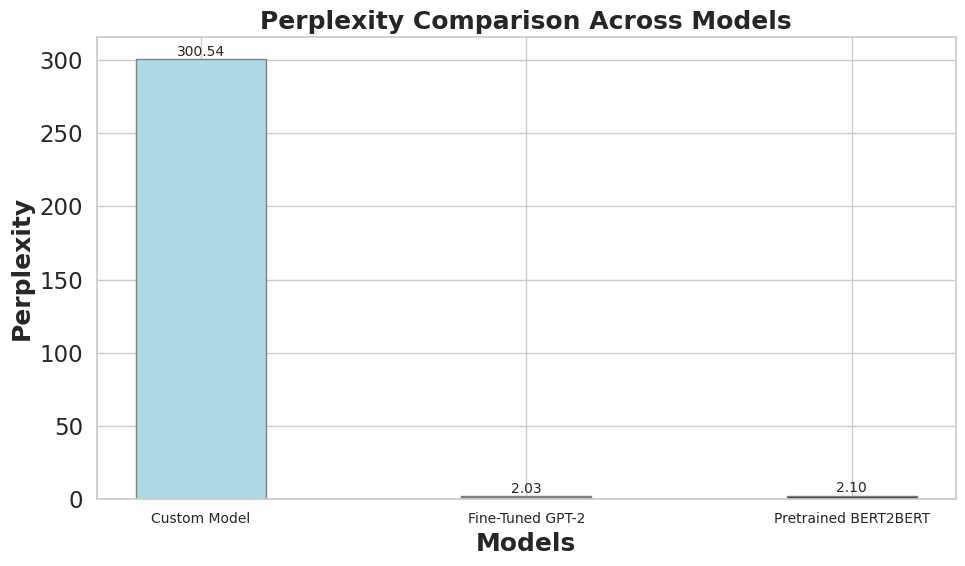

In [38]:
#models = ["Custom Model", "Fine-Tuned GPT-2", "Pretrained BERT2BERT"]

# Perplexity values for each model
perplexities = [
    perplexity_scratch,
    perplexity_ft,
    perplexity_bert2bert_generated
]

# Plotting the perplexity bar chart
plt.figure(figsize=(10, 6))  # Set the figure size for consistency
bar_width = 0.4  # Set the width of the bars
r1 = np.arange(len(models))

# Create bars for each model's perplexity
plt.bar(
    r1, perplexities,
    color=['lightblue', 'grey', 'darkgreen'],
    width=bar_width,
    edgecolor='grey'
)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Perplexity', fontweight='bold')
plt.title('Perplexity Comparison Across Models', fontweight='bold')
plt.xticks(r1, models, fontsize=10)

# Add the perplexity values on top of the bars
for i in range(len(models)):
    plt.text(
        r1[i], perplexities[i] + 0.5,
        f'{perplexities[i]:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


##Calculating BLEU Scores for Generated Text

In [39]:
# - The BLEU score is a metric for evaluating a generated sentence to a
#   reference sentence.
# - It measures how many n-grams in the generated text match those in the
#   reference text.
def calculate_bleu(reference, candidate):
    reference_tokens = reference.split()  # Tokenize the reference text
    candidate_tokens = candidate.split()  # Tokenize the generated text
    return sentence_bleu([reference_tokens], candidate_tokens)

# Reference text for BLEU score comparison
reference_text = (
    "Sequential recommender systems are an important and demanded area of research. "
    "Such systems aim to use the order of interactions in a user's history to predict "
    "future interactions. The premise is that the order of interactions and sequential "
    "patterns play an essential role. Therefore, it is crucial to use datasets that "
    "exhibit a sequential structure to evaluate sequential recommenders properly."
)

# Calculate BLEU scores for the generated texts
bleu_scratch = calculate_bleu(reference_text, generated_text_scratch)
bleu_finetuned = calculate_bleu(reference_text, generated_text_finetuned)
bleu_pretrained = calculate_bleu(reference_text, generated_text_pretrained)

# Print the BLEU scores
print(f"BLEU Score (Custom Model): {bleu_scratch}")
print(f"BLEU Score (Fine-Tuned GPT-2): {bleu_finetuned}")
print(f"BLEU Score (Pretrained BERT2BERT): {bleu_pretrained}")


BLEU Score (Custom Model): 0.09630194052857179
BLEU Score (Fine-Tuned GPT-2): 0.15242648887877316
BLEU Score (Pretrained BERT2BERT): 0.11012227216122682


##Plotting BLEU Score Comparison Across Models

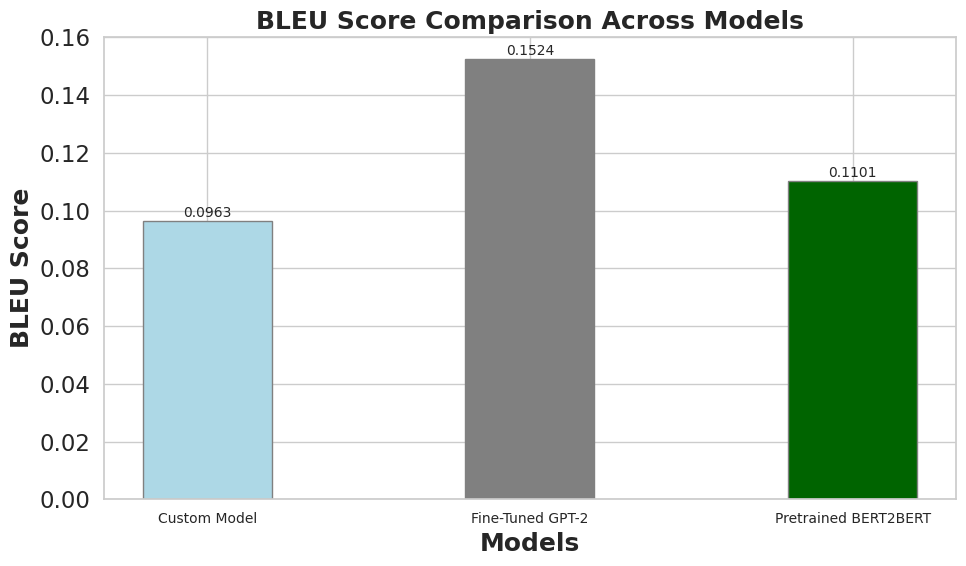

In [48]:
# BLEU scores for each model
bleu_scores = [bleu_scratch, bleu_finetuned, bleu_pretrained]

# Plotting the BLEU score bar chart
plt.figure(figsize=(10, 6))  # Set the figure size for consistency
bar_width = 0.4  # Set the width of the bars
r1 = np.arange(len(models))  # The x locations for the groups

# Create bars for each model's BLEU score
plt.bar(
    r1, bleu_scores,
    color=['lightblue', 'grey', 'darkgreen'],
    width=bar_width,
    edgecolor='grey'
)

# Set the labels and title for the plot
plt.xlabel('Models', fontweight='bold')
plt.ylabel('BLEU Score', fontweight='bold')
plt.title('BLEU Score Comparison Across Models', fontweight='bold')
plt.xticks(r1, models, fontsize=10)

# Add the BLEU scores on top of the bars
for i in range(len(models)):
    plt.text(
        r1[i], bleu_scores[i] + 0.0005,
        f'{bleu_scores[i]:.4f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


##Calculating METEOR Scores for Generated Text

In [41]:
# METEOR (Metric for Evaluation of Translation with Explicit ORdering) is a metric
# for evaluating the quality of machine-translated text.
def calculate_meteor(reference, candidate):
    # Tokenize the input strings before calculating the METEOR score
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    return meteor_score([reference_tokens], candidate_tokens)

# Calculate METEOR scores for the generated texts
meteor_scratch = calculate_meteor(reference_text, generated_text_scratch)
meteor_finetuned = calculate_meteor(reference_text, generated_text_finetuned)
meteor_pretrained = calculate_meteor(reference_text, generated_text_pretrained)

# Print the METEOR scores for each model
print(f"METEOR Score (Custom Model): {meteor_scratch}")
print(f"METEOR Score (Fine-Tuned GPT-2): {meteor_finetuned}")
print(f"METEOR Score (Pretrained BERT2BERT): {meteor_pretrained}")


METEOR Score (Custom Model): 0.1271860095389507
METEOR Score (Fine-Tuned GPT-2): 0.36958589260947106
METEOR Score (Pretrained BERT2BERT): 0.23479550752278022


##Plotting METEOR Score Comparison Across Models

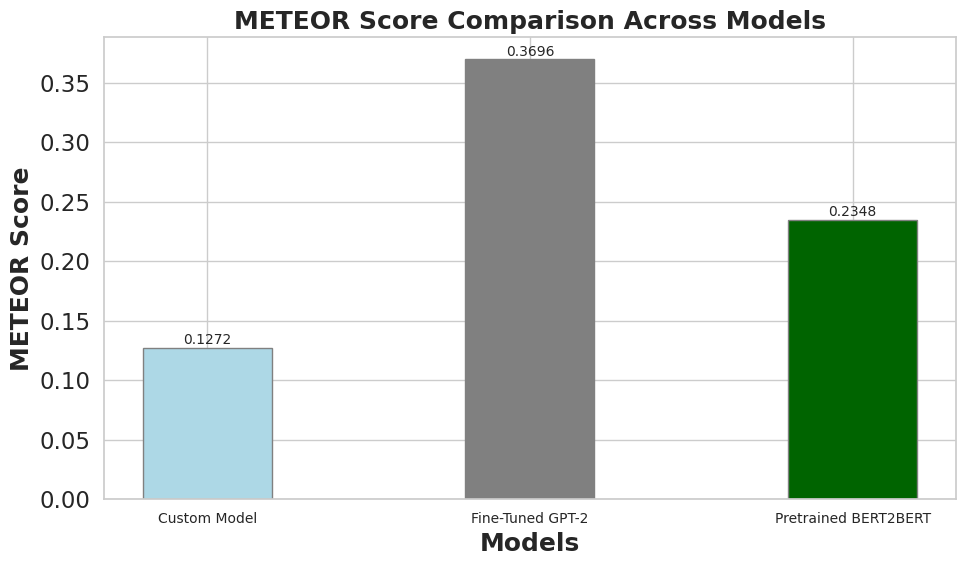

In [49]:
# METEOR scores for each model
meteor_scores = [meteor_scratch, meteor_finetuned, meteor_pretrained]

# Plotting the METEOR score bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.4  # Set the width of the bars
r1 = np.arange(len(models))

# Create bars for each model's METEOR score
plt.bar(
    r1, meteor_scores,
    color=['lightblue', 'grey', 'darkgreen'],
    width=bar_width,
    edgecolor='grey'
)

# Set the labels and title for the plot
plt.xlabel('Models', fontweight='bold')
plt.ylabel('METEOR Score', fontweight='bold')
plt.title('METEOR Score Comparison Across Models', fontweight='bold')
plt.xticks(r1, models, fontsize=10)

# Add the METEOR scores on top of the bars
for i in range(len(models)):
    plt.text(
        r1[i], meteor_scores[i] + 0.0005,
        f'{meteor_scores[i]:.4f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


##Calculating Distinct-N Scores for Generated Text

In [43]:
# The Distinct-N score measures the diversity of generated text by calculating the
# ratio of unique n-grams to the total number of n-grams in the text.
# A higher Distinct-N score indicates more diverse and less repetitive text.
def calculate_distinct_n(text, n=2):
    # Generate n-grams from the text
    n_grams = [tuple(text[i:i+n]) for i in range(len(text) - n + 1)]

    # Convert the list of n-grams into a set to get unique n-grams
    unique_n_grams = set(n_grams)

    # Calculate and return the Distinct-N score
    return len(unique_n_grams) / len(n_grams)

# Calculate Distinct-2 scores for the generated texts
distinct_2_scratch = calculate_distinct_n(generated_text_scratch.split(), n=2)
distinct_2_finetuned = calculate_distinct_n(generated_text_finetuned.split(),
                                            n=2)
distinct_2_pretrained = calculate_distinct_n(generated_text_pretrained.split(),
                                             n=2)

# Print the Distinct-2 scores for each model
print(f"Distinct-2 Score (Custom Model): {distinct_2_scratch}")
print(f"Distinct-2 Score (Fine-Tuned GPT-2): {distinct_2_finetuned}")
print(f"Distinct-2 Score (Pretrained BERT2BERT): {distinct_2_pretrained}")


Distinct-2 Score (Custom Model): 0.9545454545454546
Distinct-2 Score (Fine-Tuned GPT-2): 0.961038961038961
Distinct-2 Score (Pretrained BERT2BERT): 0.9090909090909091


##Plotting Distinct-2 Score Comparison Across Models

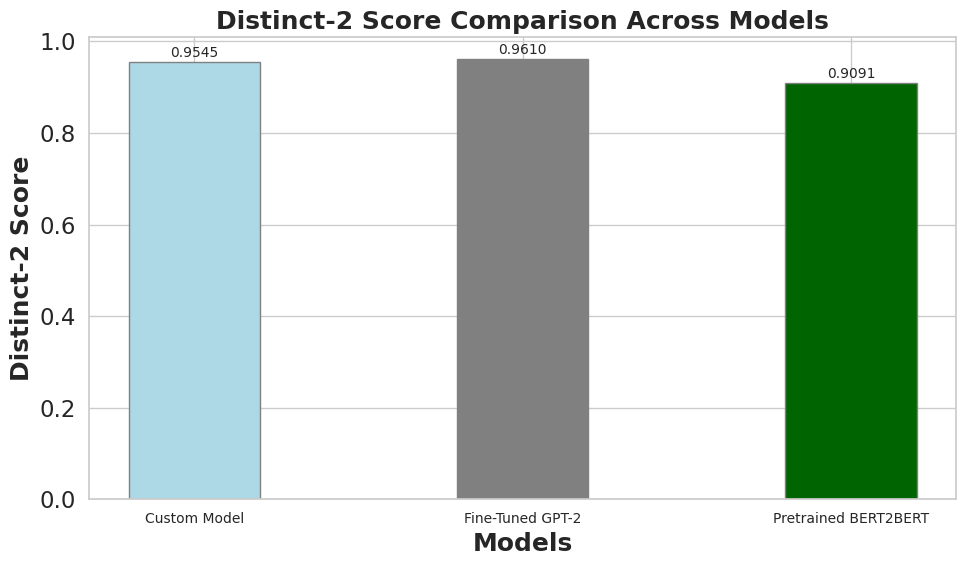

In [50]:
# Distinct-2 scores for each model
distinct_2_scores = [distinct_2_scratch, distinct_2_finetuned,
                     distinct_2_pretrained]

# Plotting the Distinct-2 score bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.4
r1 = np.arange(len(models))
# Create bars for each model's Distinct-2 score
plt.bar(
    r1, distinct_2_scores,
    color=['lightblue', 'grey', 'darkgreen'],
    width=bar_width,
    edgecolor='grey'
)

# Set the labels and title for the plot
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Distinct-2 Score', fontweight='bold')
plt.title('Distinct-2 Score Comparison Across Models', fontweight='bold')
plt.xticks(r1, models, fontsize=10)

# Add the Distinct-2 scores on top of the bars
for i in range(len(models)):
    plt.text(
        r1[i], distinct_2_scores[i] + 0.005,
        f'{distinct_2_scores[i]:.4f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


##Calculating BERTScore for Generated Texts

In [45]:
# BERTScore evaluates generated text by comparing it to a reference using
# BERT embeddings.
# It returns Precision (P), Recall (R), and F1 score, which measure the similarity
# between the generated text and the reference.
def calculate_bertscore(reference, candidate):
    P, R, F1 = score([candidate], [reference], lang="en", verbose=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# Calculate BERTScore for the generated texts from different models
precision_scratch, recall_scratch, f1_scratch = calculate_bertscore(
    reference_text, generated_text_scratch
)
precision_finetuned, recall_finetuned, f1_finetuned = calculate_bertscore(
    reference_text, generated_text_finetuned
)
precision_pretrained, recall_pretrained, f1_pretrained = calculate_bertscore(
    reference_text, generated_text_pretrained
)

# Print the BERTScore results for each model
print(
    f"BERTScore (Custom Model): P={precision_scratch}, "
    f"R={recall_scratch}, F1={f1_scratch}"
)
print(
    f"BERTScore (Fine-Tuned GPT-2): P={precision_finetuned}, "
    f"R={recall_finetuned}, F1={f1_finetuned}"
)
print(
    f"BERTScore (Pretrained BERT2BERT): P={precision_pretrained}, "
    f"R={recall_pretrained}, F1={f1_pretrained}"
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.44 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.53 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 17.58 sentences/sec
BERTScore (Custom Model): P=0.803990364074707, R=0.8420894145965576, F1=0.822598934173584
BERTScore (Fine-Tuned GPT-2): P=0.8677892684936523, R=0.8883495330810547, F1=0.877949059009552
BERTScore (Pretrained BERT2BERT): P=0.8802076578140259, R=0.8591629862785339, F1=0.8695580363273621


##Plotting BERTScore Comparison Across Models

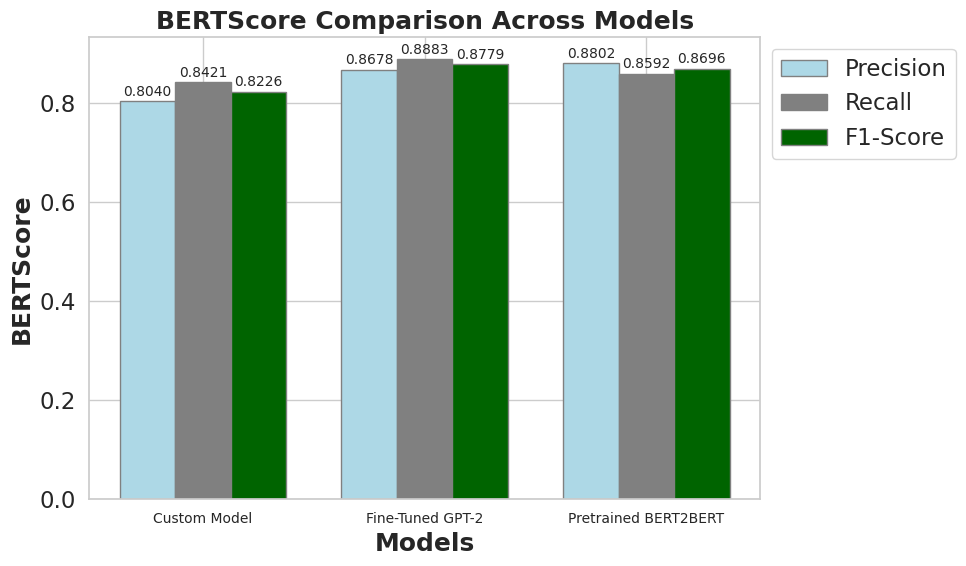

In [51]:
# BERTScore values for each model
precision_scores = [precision_scratch, precision_finetuned,
                    precision_pretrained]
recall_scores = [recall_scratch, recall_finetuned, recall_pretrained]
f1_scores = [f1_scratch, f1_finetuned, f1_pretrained]

# Plotting the BERTScore bar chart
plt.figure(figsize=(10, 6))  # Set the figure size for consistency
bar_width = 0.25  # Set the width of the bars
r1 = np.arange(len(models))  # The x locations for the groups
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars for Precision, Recall, and F1-Score
plt.bar(
    r1, precision_scores,
    color='lightblue', width=bar_width,
    edgecolor='grey', label='Precision'
)
plt.bar(
    r2, recall_scores,
    color='grey', width=bar_width,
    edgecolor='grey', label='Recall'
)
plt.bar(
    r3, f1_scores,
    color='darkgreen', width=bar_width,
    edgecolor='grey', label='F1-Score'
)

# Set the labels and title for the plot
plt.xlabel('Models', fontweight='bold')
plt.ylabel('BERTScore', fontweight='bold')
plt.title('BERTScore Comparison Across Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models, fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add the BERTScore values on top of the bars
for i in range(len(models)):
    plt.text(
        r1[i], precision_scores[i] + 0.005,
        f'{precision_scores[i]:.4f}',
        ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r2[i], recall_scores[i] + 0.005,
        f'{recall_scores[i]:.4f}',
        ha='center', va='bottom', fontsize=10
    )
    plt.text(
        r3[i], f1_scores[i] + 0.005,
        f'{f1_scores[i]:.4f}',
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


In [47]:
# # Generate the table using tabulate of BERTScores
bertscores_scratch = {
    "precision": precision_scratch,
    "recall": recall_scratch,
    "fmeasure": f1_scratch
}
bertscores_finetuned = {
    "precision": precision_finetuned,
    "recall": recall_finetuned,
    "fmeasure": f1_finetuned
}
bertscores_pretrained = {
    "precision": precision_pretrained,
    "recall": recall_pretrained,
    "fmeasure": f1_pretrained
}

# Combine the BERTScores into a list of dictionaries
data_bert = [
    {
        "Model": "Custom Model",
        "Metric": "BERTScore",
        "Precision": bertscores_scratch['precision'],
        "Recall": bertscores_scratch['recall'],
        "F1-Score": bertscores_scratch['fmeasure']
    },
    {
        "Model": "Fine-Tuned GPT-2",
        "Metric": "BERTScore",
        "Precision": bertscores_finetuned['precision'],
        "Recall": bertscores_finetuned['recall'],
        "F1-Score": bertscores_finetuned['fmeasure']
    },
    {
        "Model": "Pretrained BERT2BERT",
        "Metric": "BERTScore",
        "Precision": bertscores_pretrained['precision'],
        "Recall": bertscores_pretrained['recall'],
        "F1-Score": bertscores_pretrained['fmeasure']
    }
]

table_bert = tabulate(data_bert, headers="keys", tablefmt="grid")
print(table_bert)


+----------------------+-----------+-------------+----------+------------+
| Model                | Metric    |   Precision |   Recall |   F1-Score |
+======================+===========+=============+==========+============+
| Custom Model         | BERTScore |    0.80399  | 0.842089 |   0.822599 |
+----------------------+-----------+-------------+----------+------------+
| Fine-Tuned GPT-2     | BERTScore |    0.867789 | 0.88835  |   0.877949 |
+----------------------+-----------+-------------+----------+------------+
| Pretrained BERT2BERT | BERTScore |    0.880208 | 0.859163 |   0.869558 |
+----------------------+-----------+-------------+----------+------------+
